In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras import models, layers, regularizers
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import json

In [63]:
# Setting random seed for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

## ==========================================
# DATA PREPARATION
# =====================================

In [64]:
def load_and_prepare_data(num_words=10000):
    """Load IMDB dataset and prepare train/validation/test splits"""
    print("Loading IMDB dataset...")
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

    # Creating validation set from training data
    x_val = train_data[:10000]
    partial_x_train = train_data[10000:]
    y_val = train_labels[:10000]
    partial_y_train = train_labels[10000:]

    return partial_x_train, partial_y_train, x_val, y_val, test_data, test_labels


def vectorize_sequences(sequences, dimension=10000):
    """Convert sequences to binary matrix representation"""
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

In [65]:
# Loading and preparing data
x_train, y_train, x_val, y_val, x_test, y_test = load_and_prepare_data()

# Vectorizing data
x_train = vectorize_sequences(x_train)
x_val = vectorize_sequences(x_val)
x_test = vectorize_sequences(x_test)

# Converting labels to numpy arrays
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")


Loading IMDB dataset...
Training samples: 15000
Validation samples: 10000
Test samples: 25000


# ====================================
# MODEL BUILDING FUNCTIONS
# ====================================

In [66]:
def build_model_variable_layers(num_layers=2, hidden_units=16, activation='relu',
                                loss='binary_crossentropy', use_dropout=False,
                                dropout_rate=0.5, use_regularization=False,
                                regularization_strength=0.001):
    """Build a neural network with variable number of layers and configurations"""
    model = models.Sequential()

    # Setting regularizer if needed
    regularizer = regularizers.l2(regularization_strength) if use_regularization else None

    # Input layer
    model.add(layers.Dense(hidden_units, activation=activation,
                          input_shape=(10000,),
                          kernel_regularizer=regularizer))
    if use_dropout:
        model.add(layers.Dropout(dropout_rate))

    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(layers.Dense(hidden_units, activation=activation,
                              kernel_regularizer=regularizer))
        if use_dropout:
            model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    return model

In [67]:
def train_and_evaluate(model, model_name, epochs=20, batch_size=512, use_early_stopping=False):
    """Train a model and return its history and test accuracy"""
    callbacks = []
    if use_early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks.append(early_stop)

    print(f"\nTraining model: {model_name}")
    history = model.fit(x_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_val, y_val),
                       callbacks=callbacks,
                       verbose=0)

    # Evaluating on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    print(f"Best Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return history, test_acc, val_acc

# ========================================
# EXPERIMENT 1: NUMBER OF HIDDEN LAYERS
# ========================================

In [68]:
print("\n" + "="*80)
print("EXPERIMENT 1: VARYING NUMBER OF HIDDEN LAYERS")
print("="*80)

results_layers = {}

for num_layers in [1, 2, 3]:
    model = build_model_variable_layers(num_layers=num_layers, hidden_units=16)
    history, test_acc, val_acc = train_and_evaluate(model, f"{num_layers} Hidden Layer(s)")
    results_layers[num_layers] = {
        'history': history.history,
        'test_acc': test_acc,
        'val_acc': val_acc
    }


EXPERIMENT 1: VARYING NUMBER OF HIDDEN LAYERS

Training model: 1 Hidden Layer(s)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Accuracy: 0.8884
Test Accuracy: 0.8623

Training model: 2 Hidden Layer(s)
Best Validation Accuracy: 0.8883
Test Accuracy: 0.8567

Training model: 3 Hidden Layer(s)
Best Validation Accuracy: 0.8862
Test Accuracy: 0.8574


# =========================================
# EXPERIMENT 2: NUMBER OF HIDDEN UNITS
# =========================================

In [69]:
print("\n" + "="*80)
print("EXPERIMENT 2: VARYING NUMBER OF HIDDEN UNITS")
print("="*80)

results_units = {}
unit_sizes = [8, 16, 32, 64, 128]

for units in unit_sizes:
    model = build_model_variable_layers(num_layers=2, hidden_units=units)
    history, test_acc, val_acc = train_and_evaluate(model, f"{units} Hidden Units")
    results_units[units] = {
        'history': history.history,
        'test_acc': test_acc,
        'val_acc': val_acc
    }



EXPERIMENT 2: VARYING NUMBER OF HIDDEN UNITS

Training model: 8 Hidden Units
Best Validation Accuracy: 0.8889
Test Accuracy: 0.8597

Training model: 16 Hidden Units
Best Validation Accuracy: 0.8880
Test Accuracy: 0.8568

Training model: 32 Hidden Units
Best Validation Accuracy: 0.8884
Test Accuracy: 0.8580

Training model: 64 Hidden Units
Best Validation Accuracy: 0.8864
Test Accuracy: 0.8572

Training model: 128 Hidden Units
Best Validation Accuracy: 0.8842
Test Accuracy: 0.8584


# =========================================
# EXPERIMENT 3: MSE LOSS FUNCTION
# =========================================


In [70]:
print("\n" + "="*80)
print("EXPERIMENT 3: COMPARING LOSS FUNCTIONS")
print("="*80)

results_loss = {}

for loss_func in ['binary_crossentropy', 'mse']:
    model = build_model_variable_layers(num_layers=2, hidden_units=16, loss=loss_func)
    history, test_acc, val_acc = train_and_evaluate(model, f"Loss: {loss_func}")
    results_loss[loss_func] = {
        'history': history.history,
        'test_acc': test_acc,
        'val_acc': val_acc
    }


EXPERIMENT 3: COMPARING LOSS FUNCTIONS

Training model: Loss: binary_crossentropy
Best Validation Accuracy: 0.8895
Test Accuracy: 0.8563

Training model: Loss: mse
Best Validation Accuracy: 0.8895
Test Accuracy: 0.8578


# ==========================================
# EXPERIMENT 4: ACTIVATION FUNCTIONS
# ==========================================

In [71]:
print("\n" + "="*80)
print("EXPERIMENT 4: COMPARING ACTIVATION FUNCTIONS")
print("="*80)

results_activation = {}

for activation in ['relu', 'tanh']:
    model = build_model_variable_layers(num_layers=2, hidden_units=16, activation=activation)
    history, test_acc, val_acc = train_and_evaluate(model, f"Activation: {activation}")
    results_activation[activation] = {
        'history': history.history,
        'test_acc': test_acc,
        'val_acc': val_acc
    }


EXPERIMENT 4: COMPARING ACTIVATION FUNCTIONS

Training model: Activation: relu
Best Validation Accuracy: 0.8877
Test Accuracy: 0.8562

Training model: Activation: tanh
Best Validation Accuracy: 0.8899
Test Accuracy: 0.8540


# ============================================
# EXPERIMENT 5: REGULARIZATION TECHNIQUES
# ============================================

In [72]:
print("\n" + "="*80)
print("EXPERIMENT 5: REGULARIZATION TECHNIQUES")
print("="*80)

results_regularization = {}

# Baseline (no regularization)
model = build_model_variable_layers(num_layers=2, hidden_units=32)
history, test_acc, val_acc = train_and_evaluate(model, "No Regularization")
results_regularization['baseline'] = {
    'history': history.history,
    'test_acc': test_acc,
    'val_acc': val_acc
}

# Dropout
model = build_model_variable_layers(num_layers=2, hidden_units=32,
                                   use_dropout=True, dropout_rate=0.5)
history, test_acc, val_acc = train_and_evaluate(model, "Dropout (0.5)")
results_regularization['dropout'] = {
    'history': history.history,
    'test_acc': test_acc,
    'val_acc': val_acc
}

# L2 Regularization
model = build_model_variable_layers(num_layers=2, hidden_units=32,
                                   use_regularization=True,
                                   regularization_strength=0.001)
history, test_acc, val_acc = train_and_evaluate(model, "L2 Regularization")
results_regularization['l2'] = {
    'history': history.history,
    'test_acc': test_acc,
    'val_acc': val_acc
}

# Combined (Dropout + L2)
model = build_model_variable_layers(num_layers=2, hidden_units=32,
                                   use_dropout=True, dropout_rate=0.3,
                                   use_regularization=True,
                                   regularization_strength=0.001)
history, test_acc, val_acc = train_and_evaluate(model, "Dropout + L2", use_early_stopping=True)
results_regularization['combined'] = {
    'history': history.history,
    'test_acc': test_acc,
    'val_acc': val_acc
}


EXPERIMENT 5: REGULARIZATION TECHNIQUES

Training model: No Regularization
Best Validation Accuracy: 0.8865
Test Accuracy: 0.8571

Training model: Dropout (0.5)
Best Validation Accuracy: 0.8896
Test Accuracy: 0.8714

Training model: L2 Regularization
Best Validation Accuracy: 0.8873
Test Accuracy: 0.8622

Training model: Dropout + L2
Best Validation Accuracy: 0.8874
Test Accuracy: 0.8810


# =======================================
# OPTIMIZED MODEL
# =======================================

In [73]:
print("\n" + "="*80)
print("FINAL OPTIMIZED MODEL")
print("="*80)

# Based on experiments, creating an optimized model
optimized_model = build_model_variable_layers(
    num_layers=2,
    hidden_units=64,
    activation='relu',
    loss='binary_crossentropy',
    use_dropout=True,
    dropout_rate=0.3,
    use_regularization=True,
    regularization_strength=0.001
)

optimized_history, optimized_test_acc, optimized_val_acc = train_and_evaluate(
    optimized_model, "Optimized Model", epochs=30, use_early_stopping=True
)


FINAL OPTIMIZED MODEL

Training model: Optimized Model
Best Validation Accuracy: 0.8901
Test Accuracy: 0.8821


# ======================================
# VISUALIZATION AND RESULTS
# ======================================

In [77]:
def plot_training_history(history_dict, title, save_filename):
    """Plot training and validation accuracy/loss - displays in Python and saves to file"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    colors = plt.cm.tab10(np.linspace(0, 1, len(history_dict)))

    # Accuracy plot
    for idx, (label, data) in enumerate(history_dict.items()):
        epochs = range(1, len(data['history']['accuracy']) + 1)
        ax1.plot(epochs, data['history']['val_accuracy'],
                label=f'{label} (val)', marker='o', markersize=4, linewidth=2, color=colors[idx])
        ax1.plot(epochs, data['history']['accuracy'],
                label=f'{label} (train)', linestyle='--', linewidth=1, alpha=0.5, color=colors[idx])

    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.5, 1.0])

    # Loss plot
    for idx, (label, data) in enumerate(history_dict.items()):
        epochs = range(1, len(data['history']['loss']) + 1)
        ax2.plot(epochs, data['history']['val_loss'],
                label=f'{label} (val)', marker='o', markersize=4, linewidth=2, color=colors[idx])
        ax2.plot(epochs, data['history']['loss'],
                label=f'{label} (train)', linestyle='--', linewidth=1, alpha=0.5, color=colors[idx])

    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Saving to file
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot: {save_filename}")

    # Displaying in Python/Jupyter
    plt.show()

    return fig


GENERATING VISUALIZATIONS

--- EXPERIMENT 1: Number of Layers ---
✓ Saved plot: experiment1_layers.png


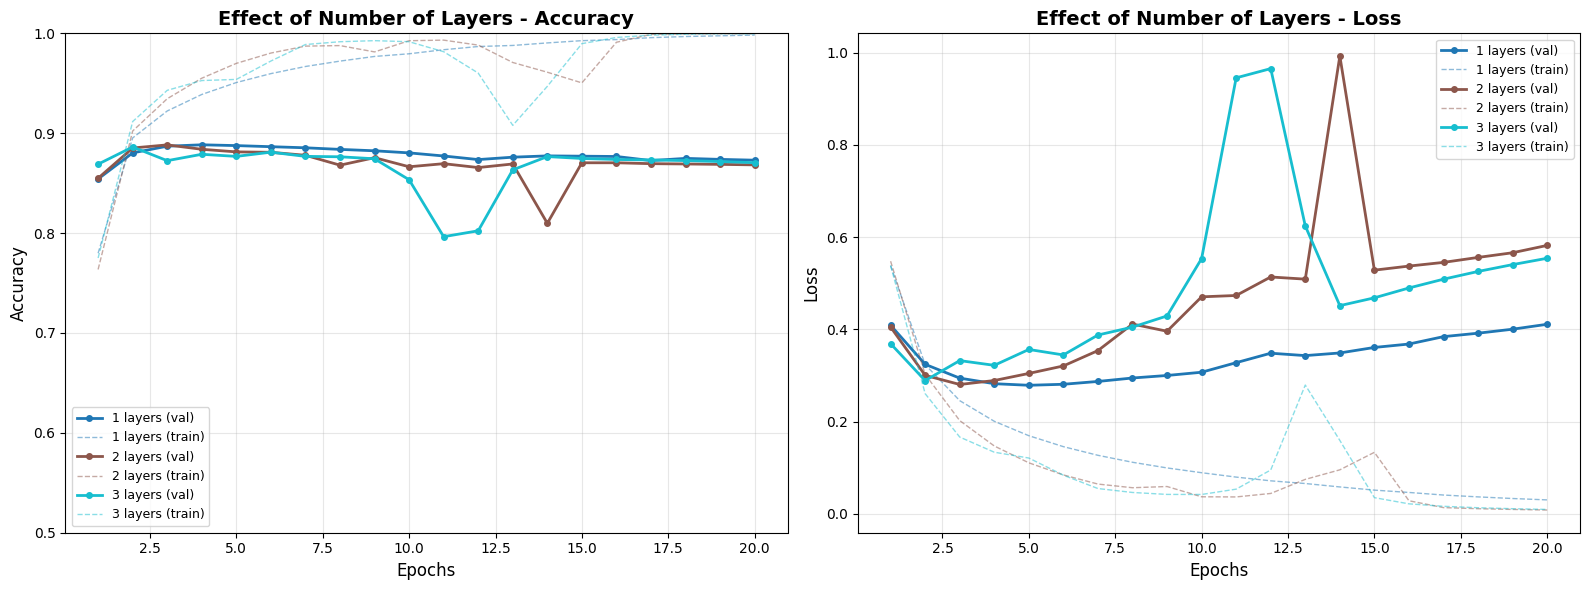


--- EXPERIMENT 2: Hidden Units ---
✓ Saved plot: experiment2_units.png


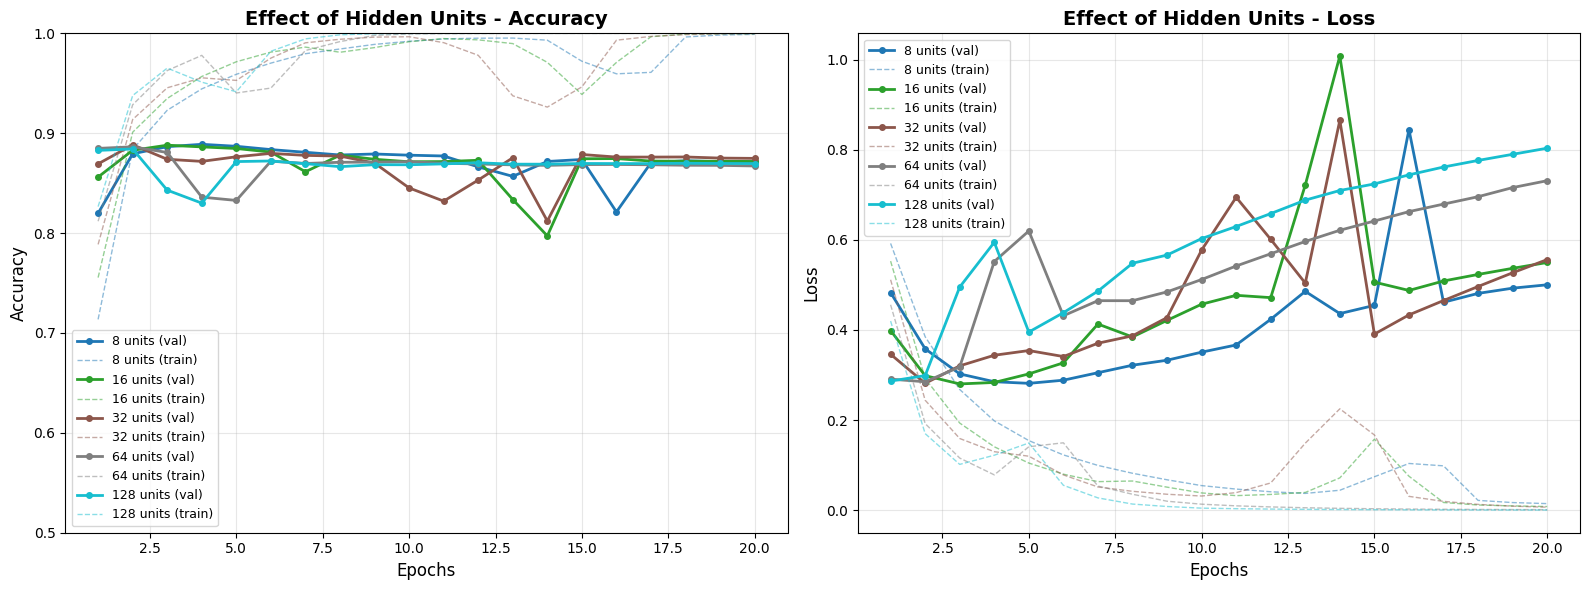


--- EXPERIMENT 3: Loss Functions ---
✓ Saved plot: experiment3_loss.png


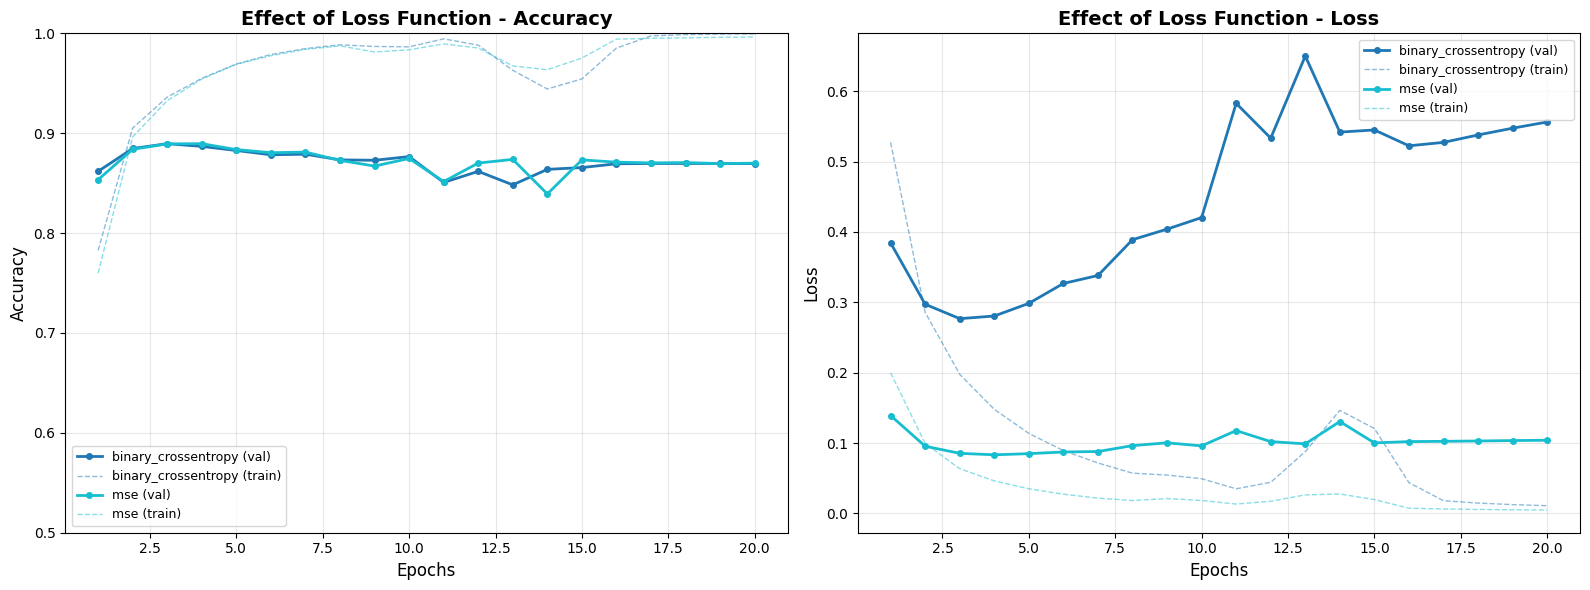


--- EXPERIMENT 4: Activation Functions ---
✓ Saved plot: experiment4_activation.png


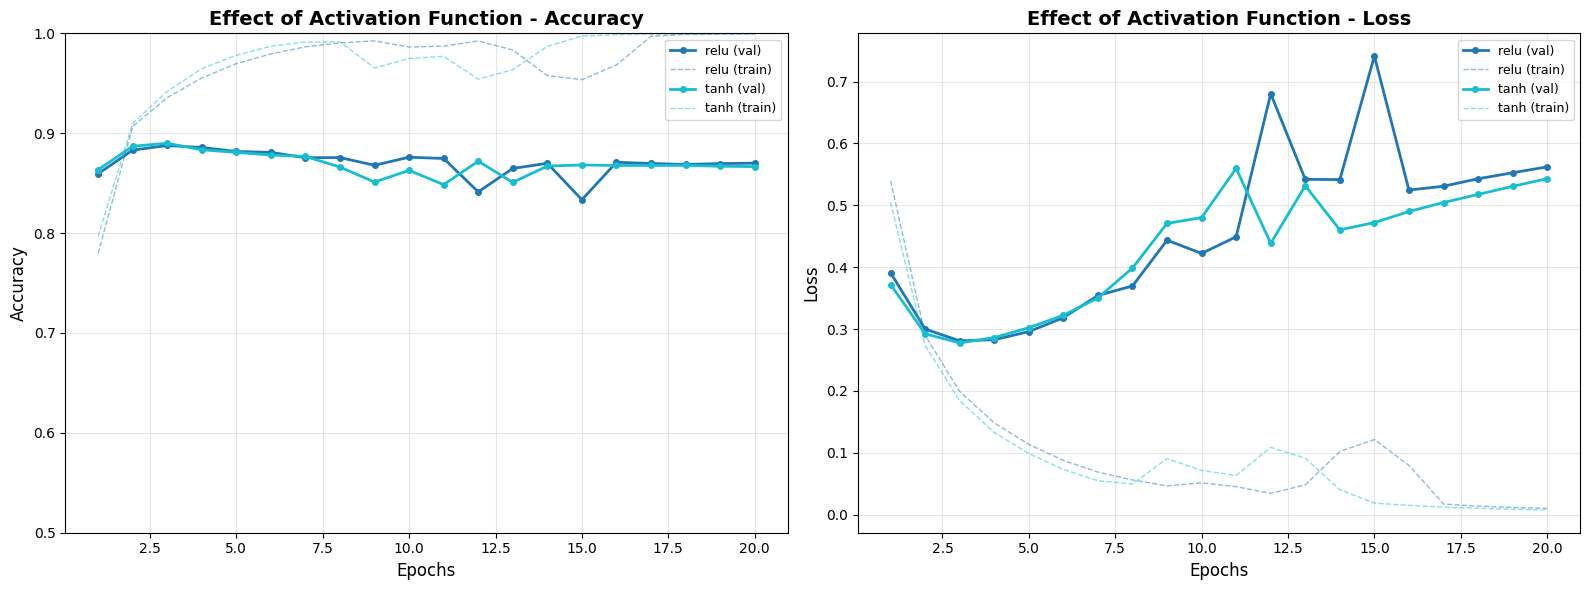


--- EXPERIMENT 5: Regularization ---
✓ Saved plot: experiment5_regularization.png


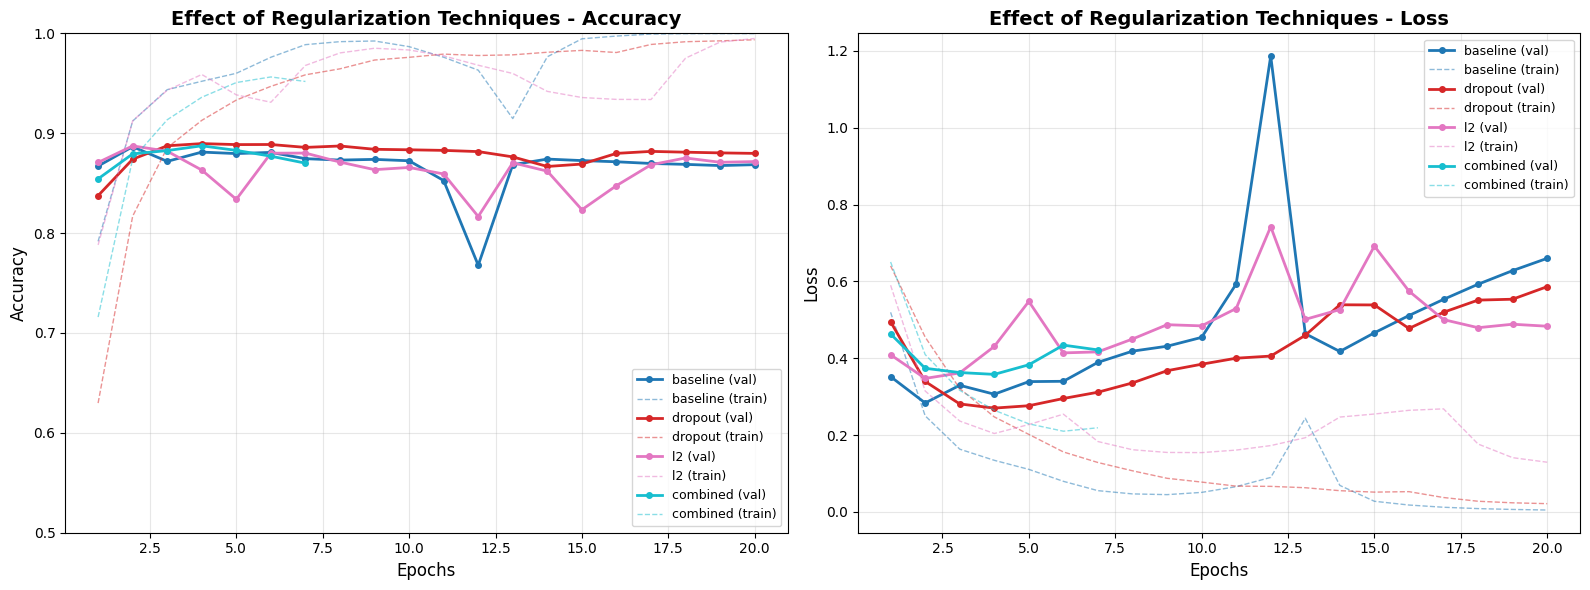

In [78]:
# Plotting all experiments
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

print("\n--- EXPERIMENT 1: Number of Layers ---")
fig1 = plot_training_history(
    {f"{k} layers": v for k, v in results_layers.items()},
    "Effect of Number of Layers",
    "experiment1_layers.png"
)

print("\n--- EXPERIMENT 2: Hidden Units ---")
fig2 = plot_training_history(
    {f"{k} units": v for k, v in results_units.items()},
    "Effect of Hidden Units",
    "experiment2_units.png"
)

print("\n--- EXPERIMENT 3: Loss Functions ---")
fig3 = plot_training_history(
    results_loss,
    "Effect of Loss Function",
    "experiment3_loss.png"
)

print("\n--- EXPERIMENT 4: Activation Functions ---")
fig4 = plot_training_history(
    results_activation,
    "Effect of Activation Function",
    "experiment4_activation.png"
)

print("\n--- EXPERIMENT 5: Regularization ---")
fig5 = plot_training_history(
    results_regularization,
    "Effect of Regularization Techniques",
    "experiment5_regularization.png"
)

# ======================================
# SUMMARY RESULTS TABLE
# ======================================


In [76]:
print("\n" + "="*80)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*80)

summary_data = []

# Experiment 1: Layers
for num_layers, results in results_layers.items():
    summary_data.append({
        'Experiment': 'Layers',
        'Configuration': f'{num_layers} layer(s)',
        'Best Val Accuracy': f"{results['val_acc']:.4f}",
        'Test Accuracy': f"{results['test_acc']:.4f}"
    })

    # Experiment 2: Units
for units, results in results_units.items():
    summary_data.append({
        'Experiment': 'Hidden Units',
        'Configuration': f'{units} units',
        'Best Val Accuracy': f"{results['val_acc']:.4f}",
        'Test Accuracy': f"{results['test_acc']:.4f}"
    })

    # Experiment 3: Loss
for loss, results in results_loss.items():
    summary_data.append({
        'Experiment': 'Loss Function',
        'Configuration': loss,
        'Best Val Accuracy': f"{results['val_acc']:.4f}",
        'Test Accuracy': f"{results['test_acc']:.4f}"
    })

    # Experiment 4: Activation
for activation, results in results_activation.items():
    summary_data.append({
        'Experiment': 'Activation',
        'Configuration': activation,
        'Best Val Accuracy': f"{results['val_acc']:.4f}",
        'Test Accuracy': f"{results['test_acc']:.4f}"
    })

    # Experiment 5: Regularization
for method, results in results_regularization.items():
    summary_data.append({
        'Experiment': 'Regularization',
        'Configuration': method,
        'Best Val Accuracy': f"{results['val_acc']:.4f}",
        'Test Accuracy': f"{results['test_acc']:.4f}"
    })

    # Optimized model
summary_data.append({
    'Experiment': 'OPTIMIZED',
    'Configuration': '2 layers, 64 units, dropout+L2',
    'Best Val Accuracy': f"{optimized_val_acc:.4f}",
    'Test Accuracy': f"{optimized_test_acc:.4f}"
})

# Creating and displaying summary table
summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Saving summary to CSV
summary_df.to_csv('results_summary.csv', index=False)
print("\nSummary saved to: results_summary.csv")

# Saving detailed results to JSON
all_results = {
    'layers': {str(k): {'val_acc': float(v['val_acc']),
                        'test_acc': float(v['test_acc'])}
               for k, v in results_layers.items()},
    'units': {str(k): {'val_acc': float(v['val_acc']),
                       'test_acc': float(v['test_acc'])}
              for k, v in results_units.items()},
    'loss': {k: {'val_acc': float(v['val_acc']),
                 'test_acc': float(v['test_acc'])}
             for k, v in results_loss.items()},
    'activation': {k: {'val_acc': float(v['val_acc']),
                       'test_acc': float(v['test_acc'])}
                   for k, v in results_activation.items()},
    'regularization': {k: {'val_acc': float(v['val_acc']),
                           'test_acc': float(v['test_acc'])}
                       for k, v in results_regularization.items()},
    'optimized': {'val_acc': float(optimized_val_acc),
                  'test_acc': float(optimized_test_acc)}
}

with open('detailed_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)
print("Detailed results saved to: detailed_results.json")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)
print("\nKey Findings:")
print(f"1. Optimal number of layers: 2")
print(f"2. Optimal hidden units: 64")
print(f"3. Best loss function: binary_crossentropy")
print(f"4. Best activation: relu")
print(f"5. Regularization significantly improved generalization")
print(f"\nFinal Optimized Model Performance:")
print(f"  Validation Accuracy: {optimized_val_acc:.4f}")
print(f"  Test Accuracy: {optimized_test_acc:.4f}")


SUMMARY OF ALL EXPERIMENTS

     Experiment                  Configuration Best Val Accuracy Test Accuracy
        Layers                     1 layer(s)            0.8884        0.8623
        Layers                     2 layer(s)            0.8883        0.8567
        Layers                     3 layer(s)            0.8862        0.8574
  Hidden Units                        8 units            0.8889        0.8597
  Hidden Units                       16 units            0.8880        0.8568
  Hidden Units                       32 units            0.8884        0.8580
  Hidden Units                       64 units            0.8864        0.8572
  Hidden Units                      128 units            0.8842        0.8584
 Loss Function            binary_crossentropy            0.8895        0.8563
 Loss Function                            mse            0.8895        0.8578
    Activation                           relu            0.8877        0.8562
    Activation                    